# Embedding images with CNN

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import PIL
import torch, torchvision
from pathlib import Path
from itertools import islice
import numpy as np

dir_root = Path().resolve().parent
dir_word_embedding = dir_root / "word2vec_model"
dir_caption_vectors = dir_word_embedding / "vectors"
dir_images = dir_root / "data" / "img_resized"
dir_captions = dir_root / "data" / "captions"
dir_image_vectors = dir_root / "cnn_text_supervision" / "vectors"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data observation

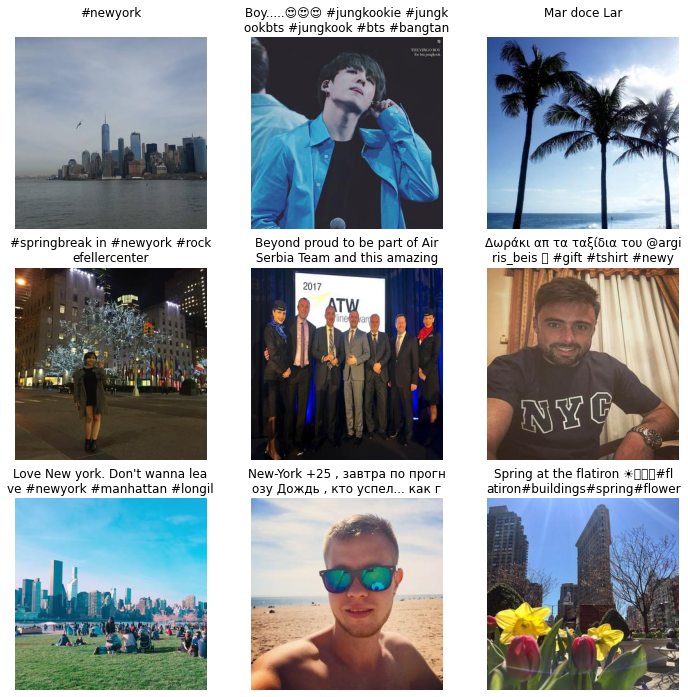

In [43]:
from itertools import islice

figure = plt.figure(figsize=(12, 12))
for i, f in enumerate(islice(dir_images.rglob("*.jpg"), 9)):
    figure.add_subplot(3, 3, i+1)
    plt.axis("off")
    caption = (dir_captions / f.relative_to(dir_images).with_suffix(".txt")).read_text()
    plt.title(caption[:30] + "\n" + caption[30:60])
    plt.imshow(PIL.Image.open(f))

## Load dataset

In [3]:
import torchvision.transforms as transforms
import PIL

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, mode): # mode is "train", "validate" or "test"
        self.dir_images = dir_images
        self.dir_target = dir_caption_vectors / mode
        self.data = [f.relative_to(self.dir_target) 
                     for f in self.dir_target.rglob("*.txt")]
        self.preprocess = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            # transforms.Resize(256), # If we want the crop to be more centered
            # transforms.CenterCrop(224), # This makes more sense for testing
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
        ])

    def __len__(self): return len(self.data)

    def __getitem__(self, i):
        f = self.data[i]
        img = PIL.Image.open(self.dir_images / f.with_suffix(".jpg")).convert('RGB')
        caption_vector = torch.from_numpy(np.loadtxt(str(self.dir_target / f)))
        return f.stem, self.preprocess(img).float(), caption_vector.float()

In [4]:
dataset = ImageDataset("train")
print(f"Shape of an image: {dataset[0][1].shape}")
print(f"Shape of an embedded caption vector: {dataset[0][2].shape}")
ndim = dataset[0][1].shape[0]

Shape of an image: torch.Size([3, 224, 224])
Shape of an embedded caption vector: torch.Size([40])


## Use ResNet50 pretrained on ImageNet

Let's see some predictions of the ResNet on our images:

--2021-07-31 20:46:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.8’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,005s  

2021-07-31 20:46:04 (2,16 MB/s) - ‘imagenet_classes.txt.8’ saved [10472/10472]

validate: 50 batchs of size 12
train: 116 batchs of size 12


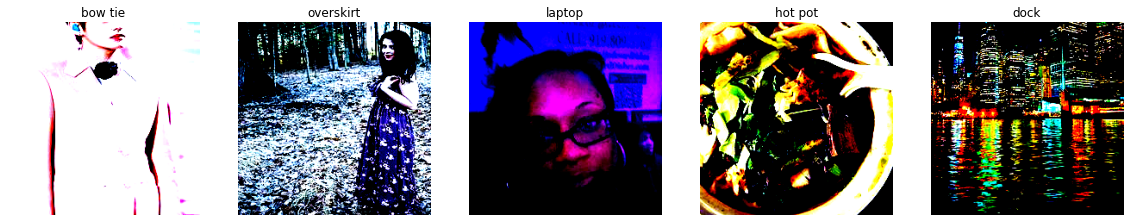

In [15]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

resnet = torchvision.models.resnet50(pretrained=True)
dataloaders = dict()
for mode in "validate", "train":
    dataloaders[mode] = torch.utils.data.DataLoader(ImageDataset(mode), batch_size=12, num_workers=8, shuffle=True, pin_memory=True)
    print(f"{mode}: {len(dataloaders[mode])} batchs of size {dataloaders[mode].batch_size}")

_, img, vector = next(iter(dataloaders["validate"]))
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(resnet(img)[0], 5)

figure = plt.figure(figsize=(20, 4))
predictions = resnet(img)
for i, p in islice(enumerate(predictions), 5):
    figure.add_subplot(1, 5, i+1)
    plt.axis("off")
    top5_prob, top5_catid = torch.topk(p, 1)
    plt.title(categories[top5_catid[0]])
    plt.imshow(img[i].permute(1, 2, 0).clip(.0, 1.))

# Model Fine-tuning

In [29]:
def train_model(model, device, criterion, optimizer, dataloaders, num_epochs=5):
    for epoch in range(1, num_epochs+1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        for phase in ['validate', 'train']:
            running_loss = .0
            if phase == 'train': model.train()
            else: model.eval()
            for _, inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()
            print(f"{phase} Loss: {running_loss / len(dataloaders[phase]):.4f}")

In [39]:
import model

model = model.Model(embedding_dimensionality=40)
resnet = resnet.to(device)
if torch.cuda.device_count() > 1:
    resnet = torch.nn.DataParallel(resnet)

dataloaders = dict()
for mode in "validate", "train":
    dataloaders[mode] = torch.utils.data.DataLoader(ImageDataset(mode), batch_size=10, num_workers=8, shuffle=True, pin_memory=True)
    print(f"{mode}: {len(dataloaders[mode])} batchs of size {dataloaders[mode].batch_size}")
criterion = torch.nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.1)
# torch.optim.SGD(resnet.parameters(), .01, momentum=.9, weight_decay=1e-4)
train_model(resnet, device, criterion, optimizer, dataloaders, num_epochs=10)

validate: 20 batchs of size 10
train: 139 batchs of size 10

Epoch 1/10
validate Loss: 149.7605
train Loss: 32.9179

Epoch 2/10
validate Loss: 670.9474
train Loss: 24.7940

Epoch 3/10
validate Loss: 2447.5788
train Loss: 25.0832

Epoch 4/10
validate Loss: 25.1013
train Loss: 23.5218

Epoch 5/10
validate Loss: 26.9737
train Loss: 23.3724

Epoch 6/10
validate Loss: 25.4877
train Loss: 23.4338

Epoch 7/10
validate Loss: 24.6277
train Loss: 23.2149

Epoch 8/10
validate Loss: 43.1188
train Loss: 23.0621

Epoch 9/10
validate Loss: 76.5499
train Loss: 23.2785

Epoch 10/10
validate Loss: 57.0693
train Loss: 24.3738


In [ ]:
for img_name, img, _ in dataloaders["validate"]:
    vectors = model(img.to("cuda"))
    for i, v in enumerate(vectors):
        torch.save(v, dir_image_vectors / img_name[i])

tensor([-0.1003, -2.6222, -0.6314, -2.3353,  0.8267, -0.9164, -1.0837,  1.4113,
        -0.9797,  0.6089, -0.6078, -1.5620,  3.3415,  0.2829,  1.8538,  2.9801,
         0.6093, -0.4359, -0.9485, -0.2013,  1.1523,  0.4530,  2.2470,  0.0226,
        -1.0616,  0.9905, -0.6435,  0.3426,  2.6060,  0.5821, -0.0376, -0.7281,
        -0.2873,  2.9346, -2.1249, -1.9650,  1.7146, -1.7574, -0.9617, -0.8609],
       device='cuda:0', grad_fn=<UnbindBackward>)
tensor([-0.1043, -2.6213, -0.6290, -2.3344,  0.8248, -0.9143, -1.0821,  1.4089,
        -0.9780,  0.6118, -0.6051, -1.5601,  3.3414,  0.2799,  1.8523,  2.9793,
         0.6132, -0.4332, -0.9520, -0.2041,  1.1504,  0.4556,  2.2449,  0.0197,
        -1.0651,  0.9971, -0.6411,  0.3455,  2.6048,  0.5792, -0.0410, -0.7269,
        -0.2905,  2.9398, -2.1287, -1.9632,  1.7135, -1.7615, -0.9597, -0.8640],
       device='cuda:0', grad_fn=<UnbindBackward>)
tensor([-1.2884e-01, -2.6036e+00, -6.1328e-01, -2.3184e+00,  8.0808e-01,
        -8.9801e-01, -1.0

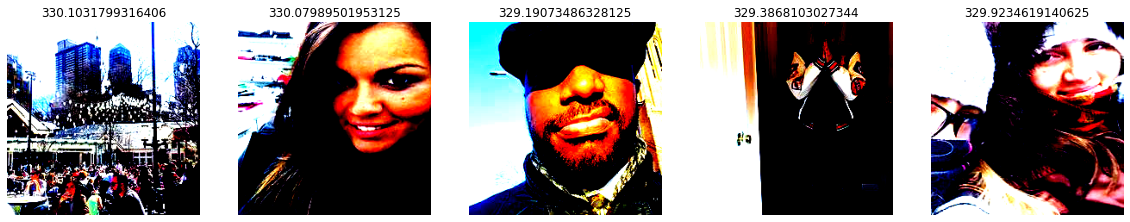

In [41]:
import heapq as hq
from gensim.models import Word2Vec

word2vec = Word2Vec.load(str(dir_word_embedding / "model_captions"))
query_vector = torch.from_numpy(word2vec.wv.get_vector("food")).to("cuda")
closest = []
n_results = 5

for img_name, img, _ in dataloaders["train"]:
    vectors = resnet(img.to("cuda"))
    for i, v in enumerate(vectors):
        d = ((v - query_vector)**2).sum(axis=0).item()
        if len(closest) < n_results:
            hq.heappush(closest, (-d, id(v), img[i], v))
        elif -closest[0][0] > d:
            hq.heappushpop(closest, (-d, id(v), img[i], v))

figure = plt.figure(figsize=(20, 4))
for i, (nd, _, img, v) in enumerate(closest):
    figure.add_subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).clip(.0, 1.))
    plt.title(str(-nd))
    print(v)